In [13]:
import os
import graphviz
from sklearn.tree import export_graphviz
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, roc_auc_score, ConfusionMatrixDisplay
)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
#print(os.getcwd())
#if os.path.basename(os.getcwd()) != 'NeuroCurve': os.chdir('NeuroCurve')

## Processing

In [14]:
os.chdir('..')
NeuroCurveOG = pd.read_csv("CSV/alzheimers_disease_data.csv")
"Drops any unnecessary features of the original dataset"
def pre_process():
    usableCSV = NeuroCurveOG.drop(columns=["PatientID", "Diabetes", "CardiovascularDisease", "DoctorInCharge", "Depression", "Depression", "SystolicBP", "DiastolicBP"])
    usableCSV.to_csv('CSV/output_CSVs/processed.csv')
pre_process()
usableCSV = pd.read_csv('CSV/output_CSVs/processed.csv')
os.chdir('NeuroPy')

X = usableCSV.drop(columns=['Diagnosis', 'Unnamed: 0'])
y = usableCSV['Diagnosis']

categorical_cols = ['Gender', 'Ethnicity', 'FamilyHistoryAlzheimers']
X[categorical_cols] = X[categorical_cols].astype('category')
X = pd.get_dummies(X, drop_first=True)  # One-hot encoding

''' Scale features '''
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Model Test Split


In [15]:
''' ----------- Train/Test Split ----------- '''
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Training

In [16]:
results = {}

''' ----------- Logistic Model Training ----------- '''
log = LogisticRegression(class_weight='balanced', max_iter=1000, penalty='l2', C=0.1, solver='liblinear')
log.fit(X_train, y_train)
results['LogisticRegression'] = {'model':log,
                                 'accuracy':accuracy_score(y_test, log.predict(X_test)), 
                                 'y_prob':log.predict_proba(X_test), 
                                 'y_pred':log.predict(X_test), 
                                 'y_prob_class1':log.predict_proba(X_test)[:, 1], 
                                 'plot_pos':(0,0,'Logistic Regression')}

'''------------- Decision Tree Model Training ---------'''
tree = DecisionTreeClassifier(random_state=2028, max_depth=5, min_samples_split=10) # 93.02 = 2028
tree.fit(X_train, y_train)
results['DecisionTree'] = {'model':tree,
                           'accuracy':accuracy_score(y_test, tree.predict(X_test)), 
                           'y_prob':tree.predict_proba(X_test), 
                           'y_pred':tree.predict(X_test), 
                           'y_prob_class1':tree.predict_proba(X_test)[:, 1], 
                           'plot_pos':(0,1,'Decision Tree')}

'''------------ Mythical Forest Model Training---------'''
forest = RandomForestClassifier(max_features='sqrt', n_estimators=len(X_train), random_state=42)
forest.fit(X_train, y_train)
print("Number of trees in the Mythical Forest: " + str(len(forest.estimators_)))
results['RandomForest'] = {'model':forest,
                           'accuracy':accuracy_score(y_test, forest.predict(X_test)), 
                           'y_prob':forest.predict_proba(X_test), 
                           'y_pred':forest.predict(X_test), 
                           'y_prob_class1':forest.predict_proba(X_test)[:, 1], 
                           'plot_pos':(0,2,'Mythical Forest')}

'''----------------Hist Gradient Boost Training--------'''
histGradient = HistGradientBoostingClassifier(max_iter=300)
histGradient.fit(X_train, y_train)
results['HistGradientBoost'] = {'model':histGradient,
                                'accuracy':accuracy_score(y_test, histGradient.predict(X_test)), 
                                'y_prob':histGradient.predict_proba(X_test), 
                                'y_pred':histGradient.predict(X_test), 
                                'y_prob_class1':histGradient.predict_proba(X_test)[:, 1], 
                                'plot_pos':(1,0,'Hist Gradient Boost')}

'''----------------XG Boost Training-------------------------'''
xgBoost = XGBClassifier(n_estimators=len(X_train), eval_metric='logloss')
xgBoost.fit(X_train, y_train)
results['XGBoost'] = {'model':xgBoost,
                      'accuracy':accuracy_score(y_test, xgBoost.predict(X_test)), 
                      'y_prob':xgBoost.predict_proba(X_test), 
                      'y_pred':xgBoost.predict(X_test), 
                      'y_prob_class1':xgBoost.predict_proba(X_test)[:, 1], 
                      'plot_pos':(1,1,'XGBoost')}

for model_name, metrics in results.items():
    print(f"{model_name}: {metrics['accuracy'] * 100:.2f}%")

Number of trees in the Mythical Forest: 1719
LogisticRegression: 81.40%
DecisionTree: 93.72%
RandomForest: 94.88%
HistGradientBoost: 95.35%
XGBoost: 94.88%


## Analysis

K-Fold Cross Validation

In [17]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
for model_name, metrics in results.items():
    metrics['cross_val_score_mean'] = cross_val_score(metrics['model'], X_scaled, y, cv = kf, scoring='accuracy').mean()
    print(f'Cross-validated {model_name} accuracy: {results[model_name]['cross_val_score_mean']* 100:.2f}%')

Cross-validated LogisticRegression accuracy: 82.13%
Cross-validated DecisionTree accuracy: 94.79%
Cross-validated RandomForest accuracy: 95.02%
Cross-validated HistGradientBoost accuracy: 95.07%
Cross-validated XGBoost accuracy: 94.88%


## Visualization

### Decision Tree Plot

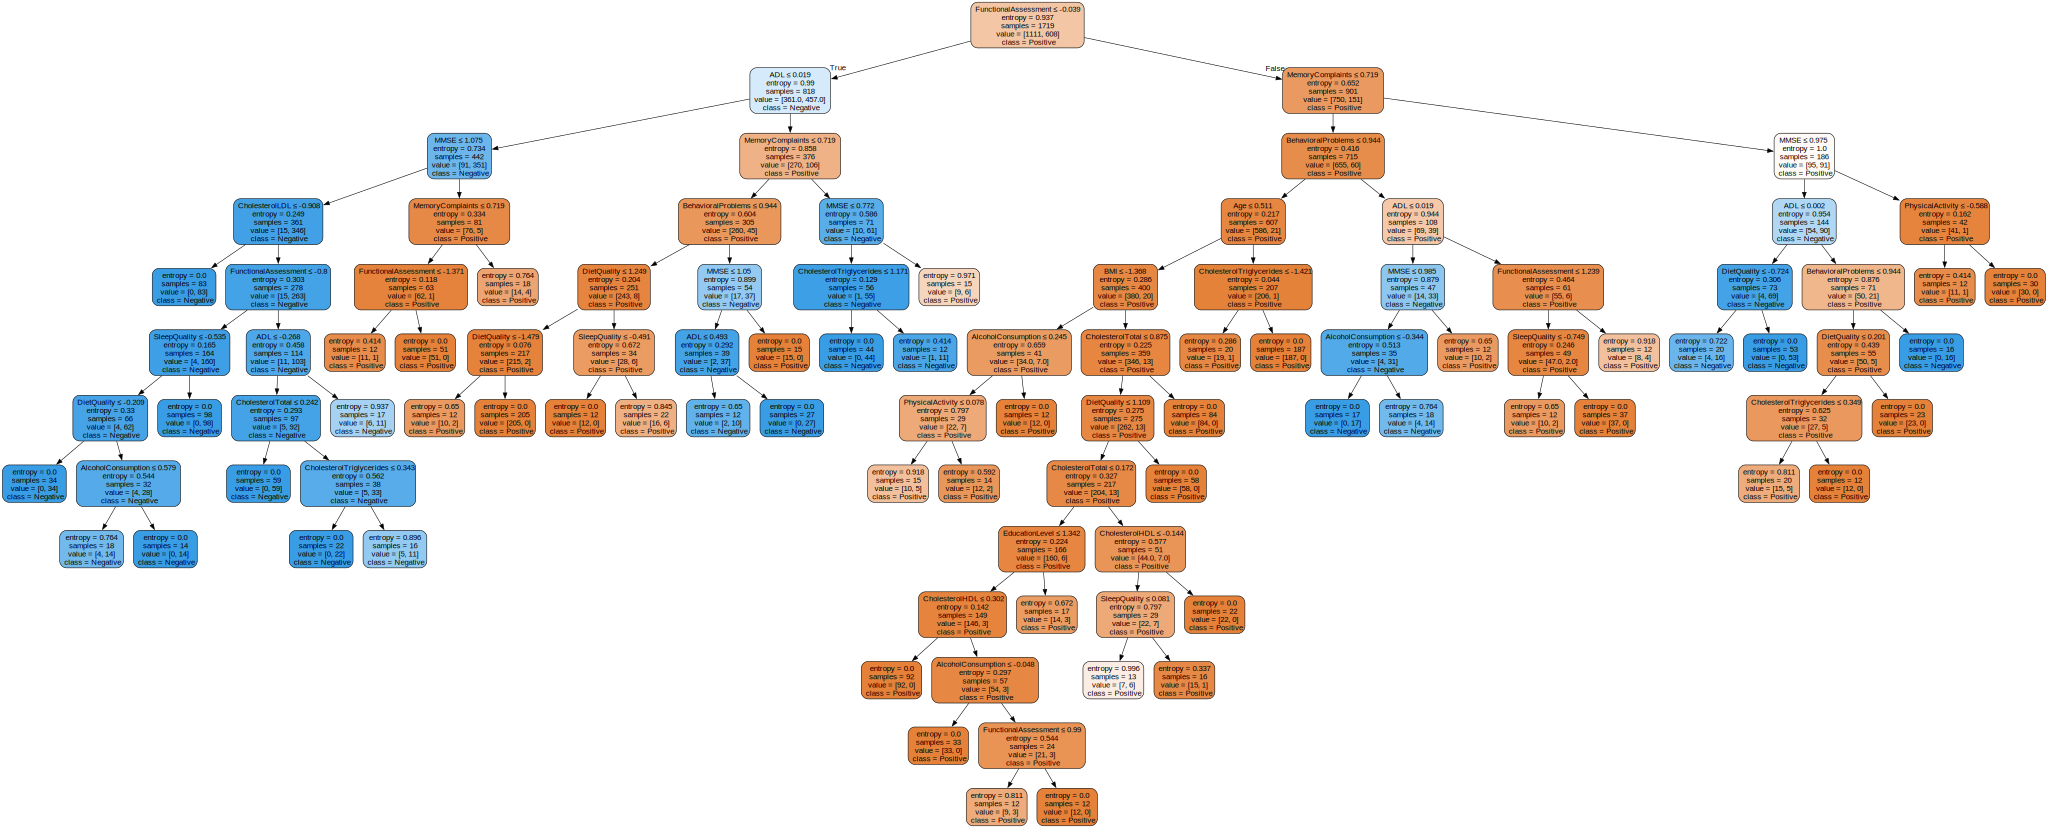

In [ ]:
dot_data = export_graphviz(tree, out_file = None,
                           feature_names=X.columns,
                           class_names=['Positive','Negative'],
                           filled=True, rounded=True,
                           special_characters=True)

graph = graphviz.Source(dot_data)
display(graph)

### Confusion Matrices

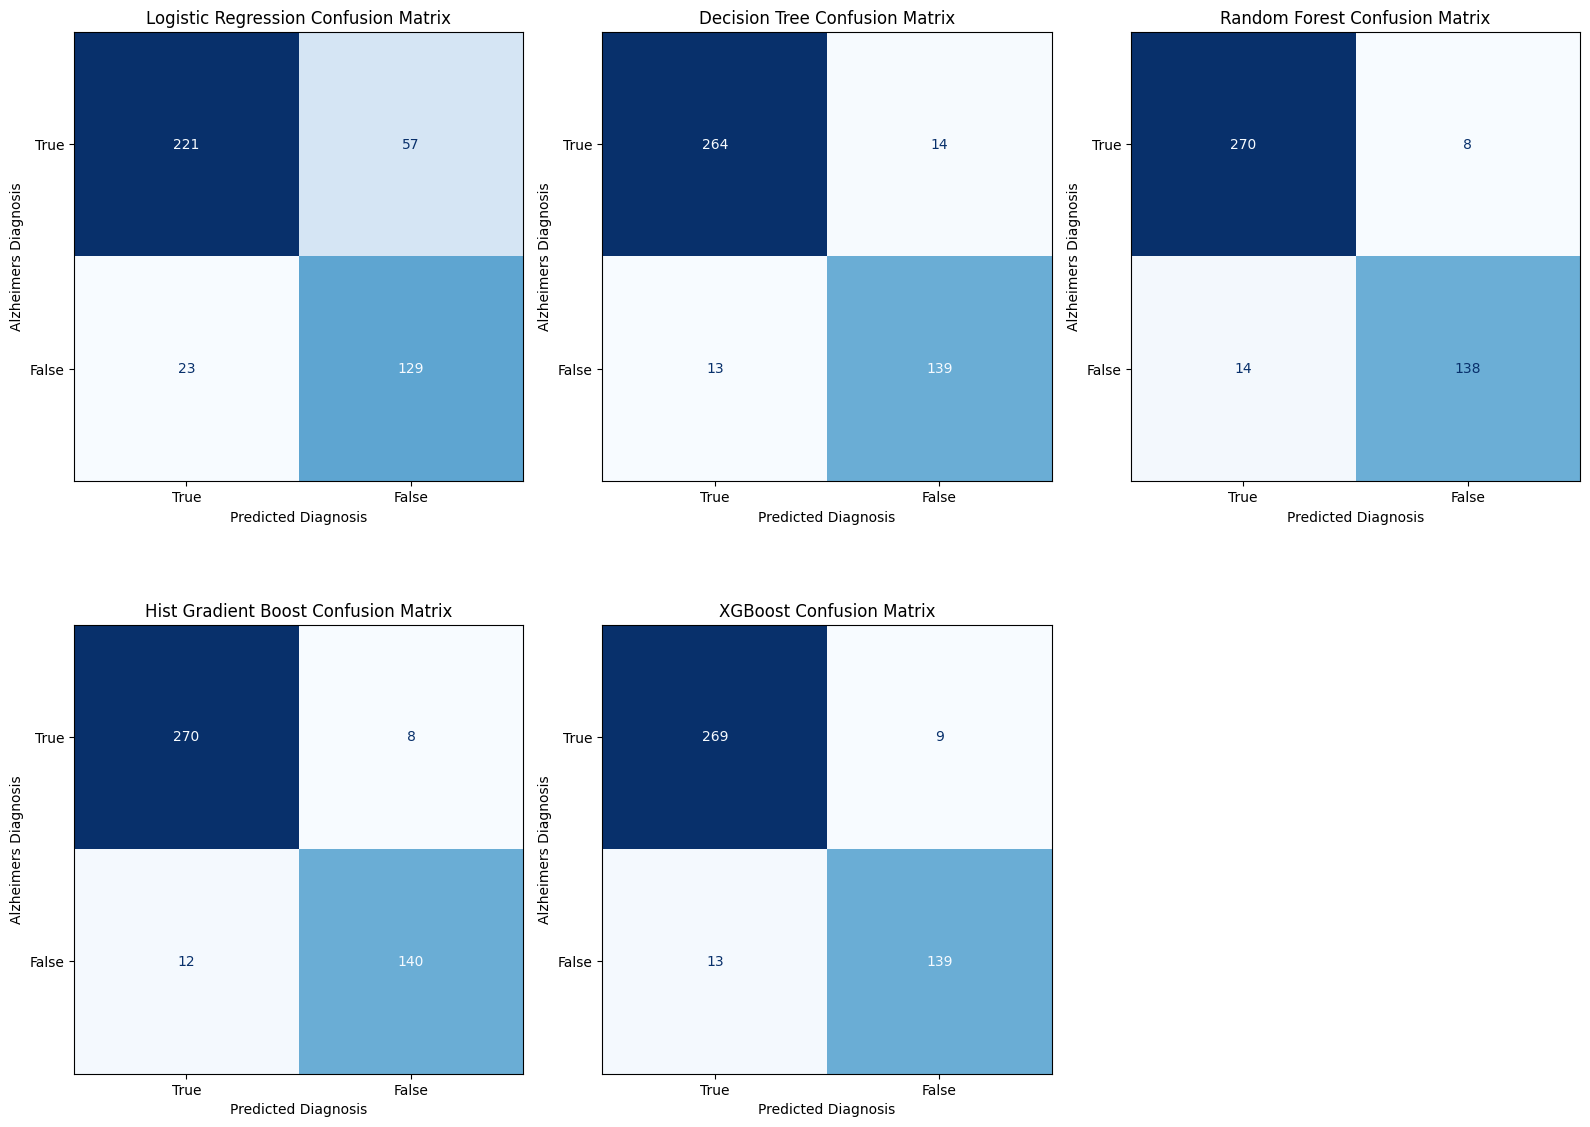

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for model_name, metrics in results.items():
    row, col, title = metrics['plot_pos']
    y_pred = metrics['y_pred']
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["True", "False"])
    disp.plot(ax=axes[row][col], colorbar=False, cmap="Blues")
    axes[row][col].set_title(f"{title} Confusion Matrix")
    axes[row][col].set_ylabel("Alzheimers Diagnosis")
    axes[row][col].set_xlabel("Predicted Diagnosis")
fig.delaxes(axes[1][2])
plt.tight_layout()
plt.show()

### Classification Reports

In [ ]:
for model_name, metrics in results.items():
    metrics['report'] = classification_report(y_test, metrics['y_pred'])
    
for model_name, metrics in results.items():
    print(f"{model_name} Classification Report:")
    print(metrics['report'])
    print('-' * 53)
    
#Logistic Regression Importance Values
'''
coefficients = log.coef_[0]
feat_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})
feat_df['AbsCoefficient'] = feat_df['Coefficient'].abs()
feat_df = feat_df.sort_values(by='AbsCoefficient', ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Feature Coefficients (Logistic Regression)')
plt.show()
'''

LogisticRegression Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85       278
           1       0.69      0.85      0.76       152

    accuracy                           0.81       430
   macro avg       0.80      0.82      0.81       430
weighted avg       0.83      0.81      0.82       430

-----------------------------------------------------
DecisionTree Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       278
           1       0.91      0.91      0.91       152

    accuracy                           0.94       430
   macro avg       0.93      0.93      0.93       430
weighted avg       0.94      0.94      0.94       430

-----------------------------------------------------
RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       278
           1   

"\ncoefficients = log.coef_[0]\nfeat_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coefficients})\nfeat_df['AbsCoefficient'] = feat_df['Coefficient'].abs()\nfeat_df = feat_df.sort_values(by='AbsCoefficient', ascending=True)\nplt.figure(figsize=(10, 6))\nplt.barh(feat_df['Feature'], feat_df['Coefficient'])\nplt.xlabel('Coefficient Value')\nplt.title('Feature Coefficients (Logistic Regression)')\nplt.show()\n"

### Receiver Operating Characteristic Curves

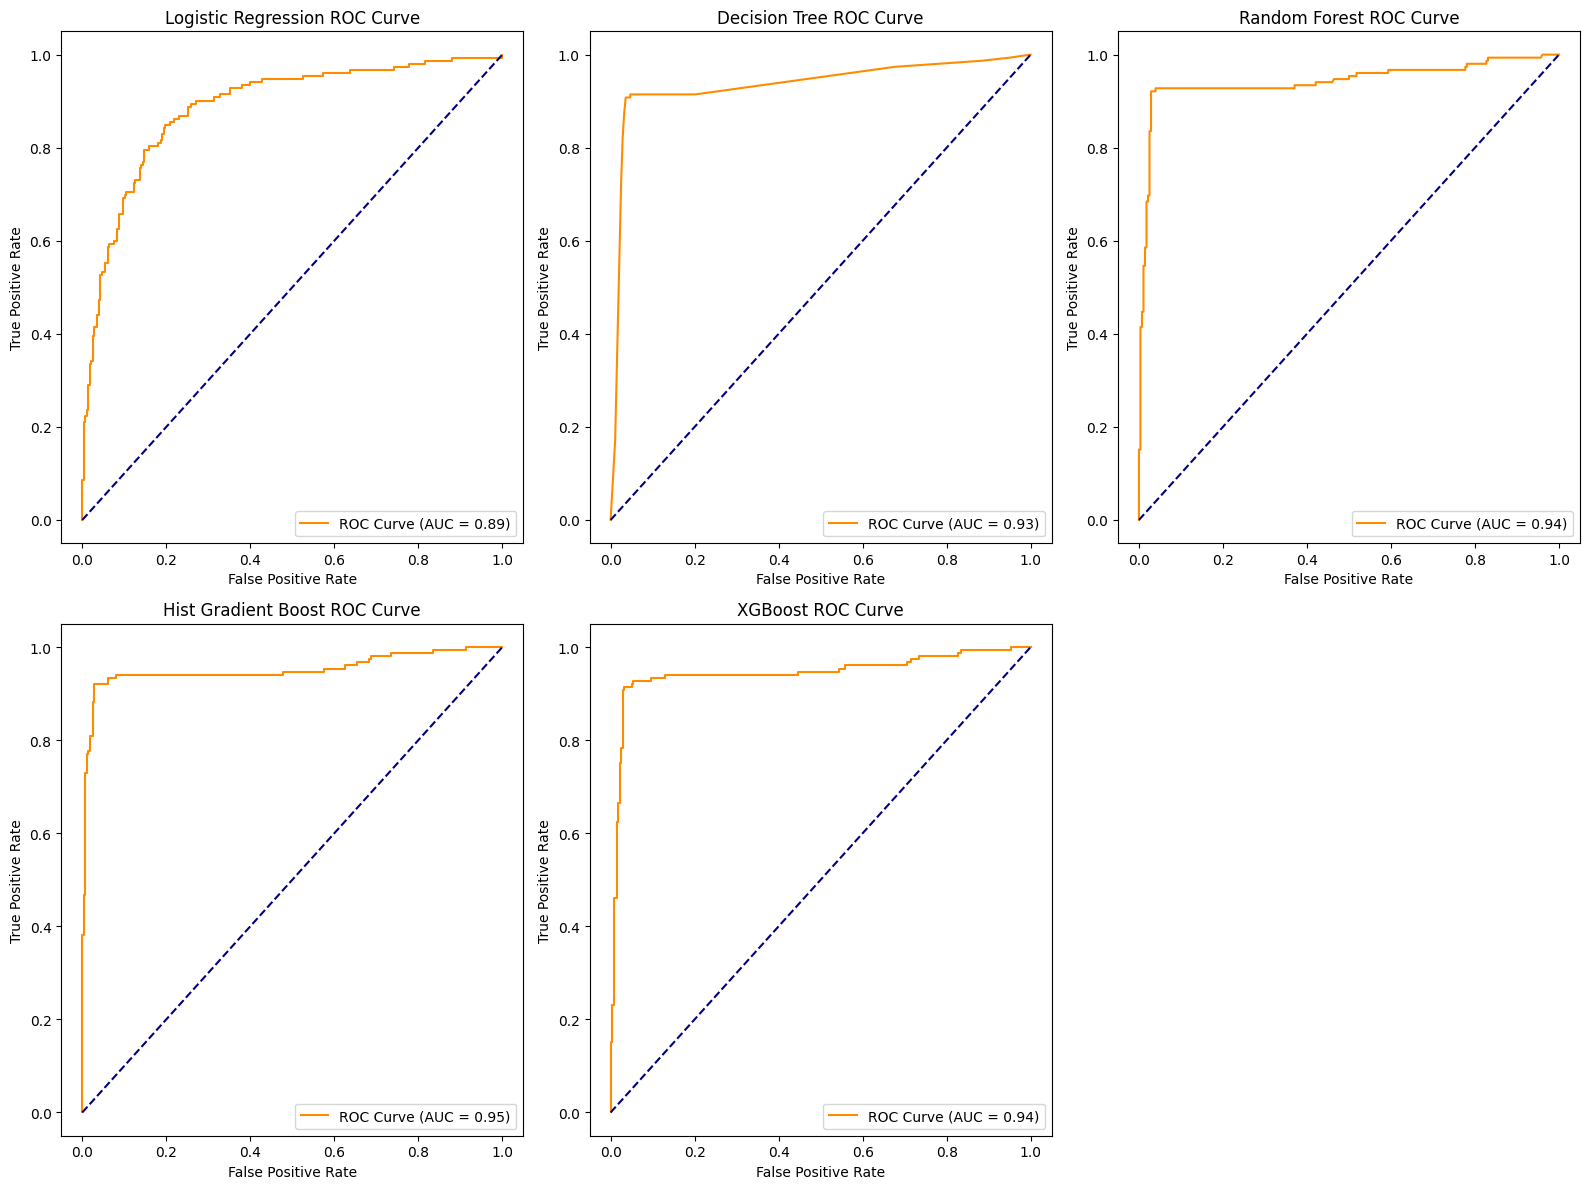

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(16, 12))
for model_name, metrics in results.items():
    row, col, title = metrics['plot_pos']
    y_prob = metrics['y_prob_class1']
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = roc_auc_score(y_test, y_prob)
    axes[row][col].plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='darkorange')
    axes[row][col].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[row][col].set_xlabel('False Positive Rate')
    axes[row][col].set_ylabel('True Positive Rate')
    axes[row][col].set_title(f'{title} ROC Curve')
    axes[row][col].legend(loc="lower right")
fig.delaxes(axes[1][2])

plt.tight_layout()
plt.show()